In [ ]:
# ALl The imports
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, average_precision_score
import time

**1.1. Download file and show the data**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")
print("Path to dataset files:", path)

100%|██████████| 742k/742k [00:00<00:00, 61.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sulianova/cardiovascular-disease-dataset/versions/1


In [ ]:
csv_file = os.path.join(path, "cardio_train.csv")
df = pd.read_csv(csv_file, sep=';')
print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [ ]:
print(df.columns)

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')


Sample size (rows, columns): (70000, 13)

Missing values per column:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Class balance (cardio):
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64
cardio
0    35021
1    34979
Name: count, dtype: int64


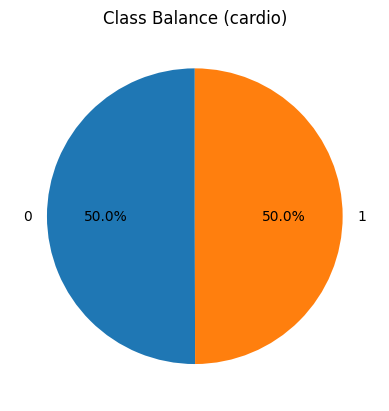


Feature distributions:
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.

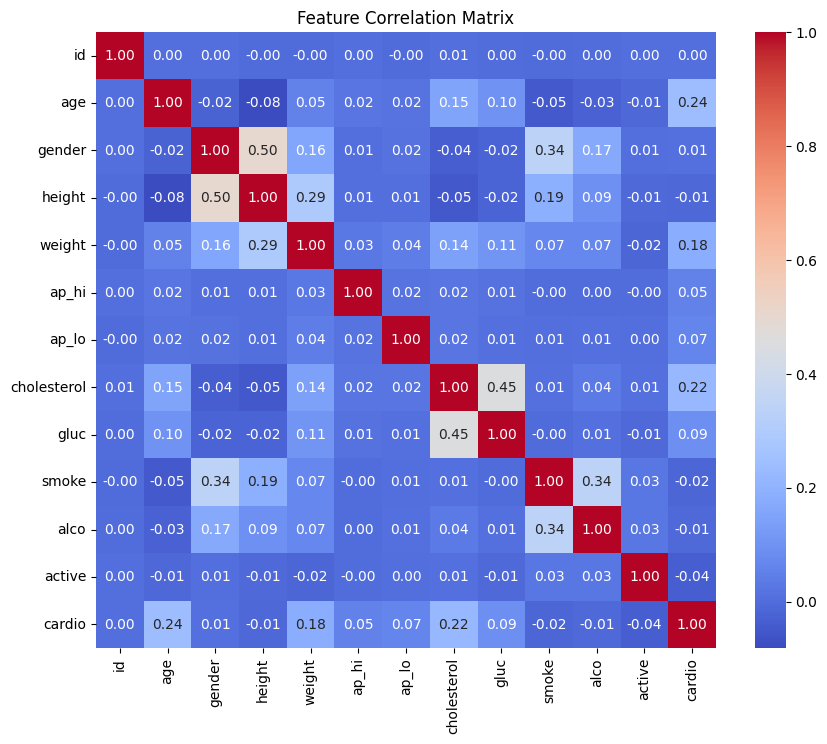

In [ ]:
# 1. Sample size
print("Sample size (rows, columns):", df.shape)

# 2. Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# 3. Class balance (target: 'cardio')
print("\nClass balance (cardio):")
print(df['cardio'].value_counts(normalize=True))  # Fraction
print(df['cardio'].value_counts())                # Absolute

# Pie chart for class balance
df['cardio'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Class Balance (cardio)')
plt.ylabel('')
plt.show()

# 4. Feature distributions & outliers
print("\nFeature distributions:")
print(df.describe())

# 5. Feature correlations

print("\nFeature correlations (Pearson):")
# Exclude the target column from the list of features
features = [col for col in df.columns if col != 'cardio']

# Now you can use this in your correlation calculation
corr = df[features + ['cardio']].corr()


# Heatmap for correlations
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

**1.2 Dataset Overview and Key Observations**

The dataset consists of 70,000 rows with 11 input features and one target variable (cardio), providing t sample size for analysis. There are no missing values, and all features are already numerically encoded, making the datasey suitable for machine learning applications. The input features include a mix of continuous variables (such as age, height, weight, and blood pressure), ordinal variables (cholesterol and glucose levels), and binary indicators (smoke, alcohol consumption, and physical activity). The target variable, cardio, is well balanced, with an approximately even distribution between classes.

Upon examining the feature distributions and correlati,g'a. 'Age is recorded in days, so converting it to years may enhance interpretabilit'y. Hei'ght a'nd wei'ght features display some extreme outliers, which may require filtering or capping to ensure data qualit'y. Blood press'ure readings (ap_hi and ap_lo) also contain implausible values, likely due to data entry errors, and should be cleaned before further analysi's. Choleste'rol a'nd gluc'ose are ordinal features and are already appropriately encoded. Correlation analysis reveals no strong collinearity among features, with the highest observed correlation being around 0.45 between cholesterol and glucose. The target variable, cardio, shows its strongest correlations with cholesterol and weight, but these relationships are modest (correlations of 0.22 and 0.18, respectivelyty.

**1.3 Data Cleaning & Feature Engineering**

In [ ]:

# 1. Convert age from days to years
df['age_years'] = (df['age'] // 365).astype(int)

# 2. Remove outliers in height and weight (using reasonable human ranges)
df = df[(df['height'] >= 100) & (df['height'] <= 220)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 180)]

# 3. Remove outliers in blood pressure
# Systolic (ap_hi): 90-250, Diastolic (ap_lo): 40-200
df = df[(df['ap_hi'] >= 90) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 40) & (df['ap_lo'] <= 200)]
# Ensure ap_hi > ap_lo
df = df[df['ap_hi'] > df['ap_lo']]


# 4. BMI calculation
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# 5. Hypertension stage (based on systolic and diastolic BP)
def hypertension_stage(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 0  # Normal
    elif 120 <= row['ap_hi'] < 140 or 80 <= row['ap_lo'] < 90:
        return 1  # Prehypertension
    elif 140 <= row['ap_hi'] < 160 or 90 <= row['ap_lo'] < 100:
        return 2  # Stage 1 Hypertension
    elif row['ap_hi'] >= 160 or row['ap_lo'] >= 100:
        return 3  # Stage 2 Hypertension
    else:
        return np.nan

df['hypertension_stage'] = df.apply(hypertension_stage, axis=1)

# 6. Age group bins (optional)
df['age_group'] = pd.cut(df['age_years'],
                         bins=[0, 30, 40, 50, 60, 100],
                         labels=['30', '35', '45', '55', '60'])

# 7. Interaction features
df['smoke_alco'] = df['smoke'] * df['alco']
df['age_chol'] = df['age_years'] * df['cholesterol']

# --- Drop columns not needed for modeling (could come back later) ---
df = df.drop(['id', 'age'], axis=1)

# Preview cleaned and engineered data
print(df.head())



   gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0       2     168    62.0    110     80            1     1      0     0   
1       1     156    85.0    140     90            3     1      0     0   
2       1     165    64.0    130     70            3     1      0     0   
3       2     169    82.0    150    100            1     1      0     0   
4       1     156    56.0    100     60            1     1      0     0   

   active  cardio  age_years        bmi  hypertension_stage age_group  \
0       1       0         50  21.967120                   1        45   
1       1       1         55  34.927679                   2        55   
2       0       1         51  23.507805                   1        55   
3       1       1         48  28.710479                   2        45   
4       0       0         47  23.011177                   0        45   

   smoke_alco  age_chol  
0           0        50  
1           0       165  
2           0       153  
3     

**1.4 EDA**

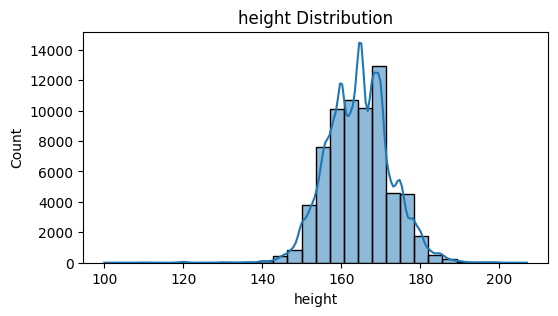

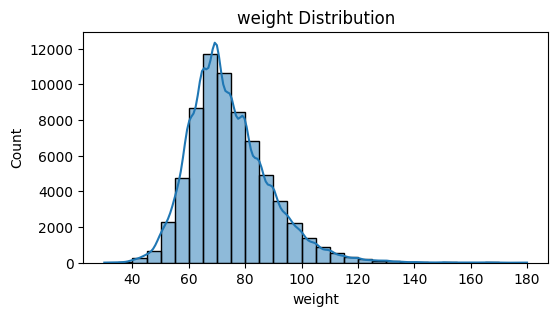

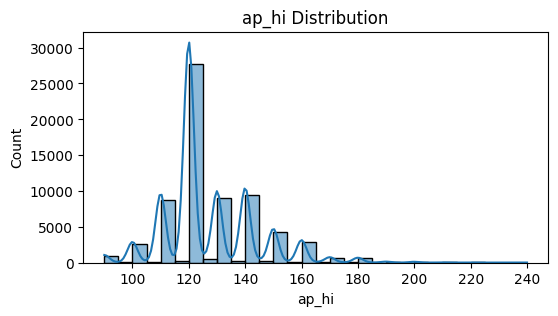

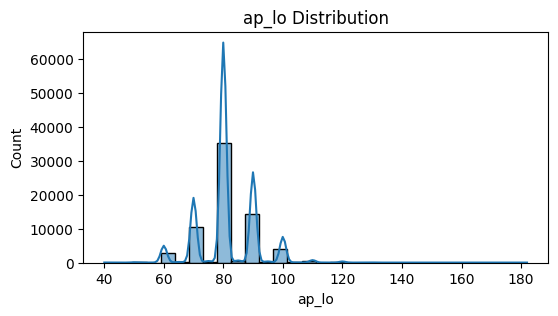

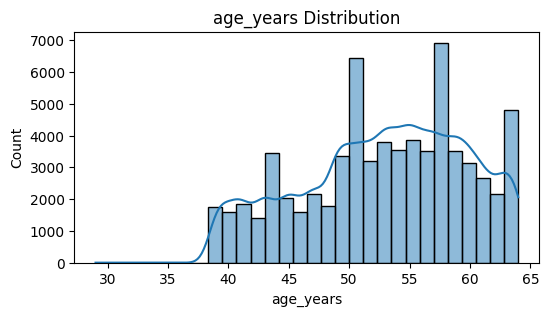

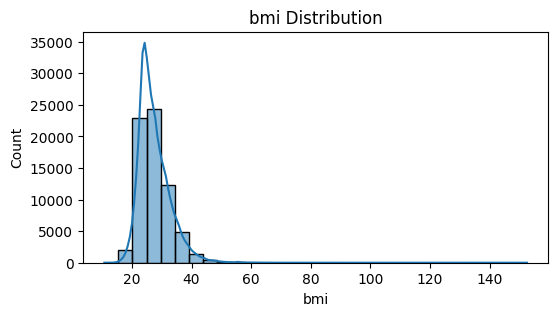

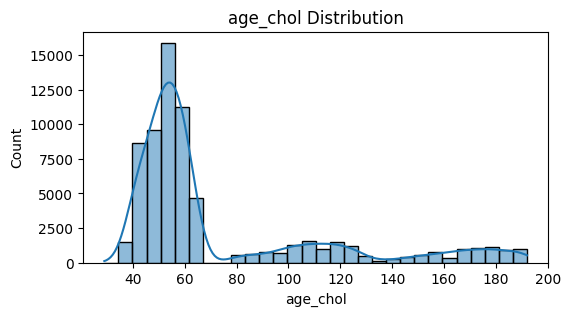

In [ ]:
# Numerical Distributions
num_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi', 'age_chol']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col].astype(float), kde=True, bins=30)
    plt.title(f'{col} Distribution')
    plt.show()


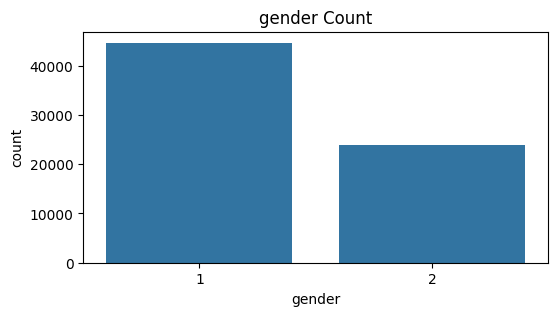

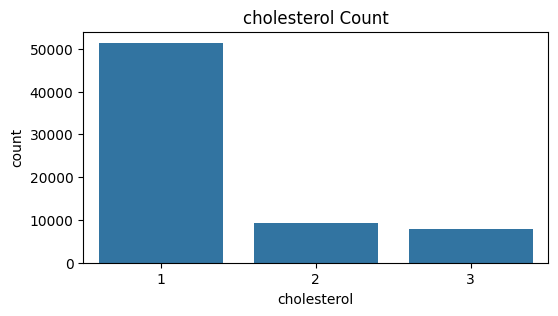

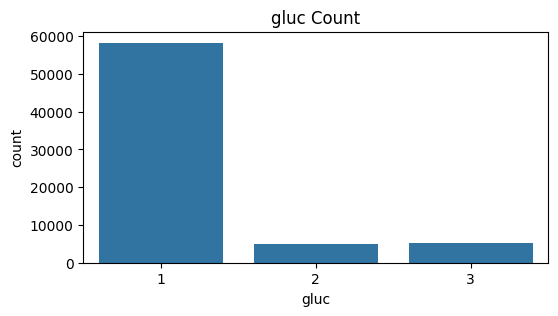

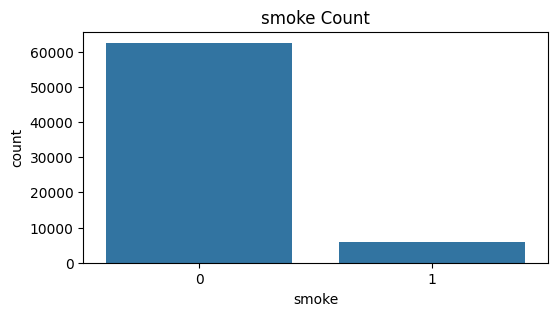

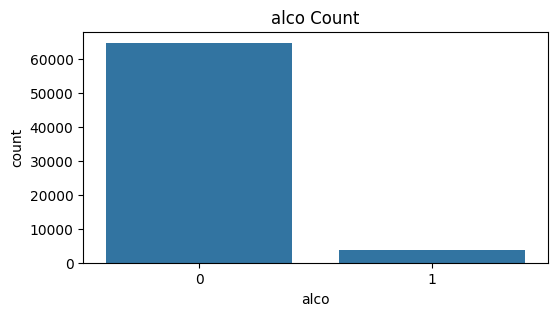

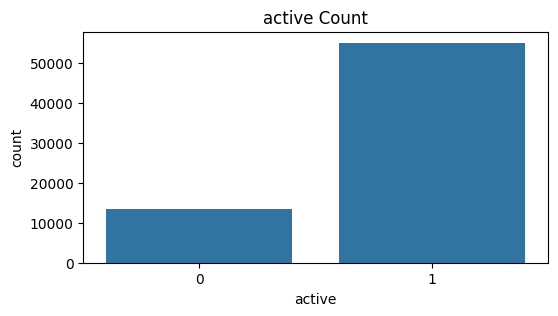

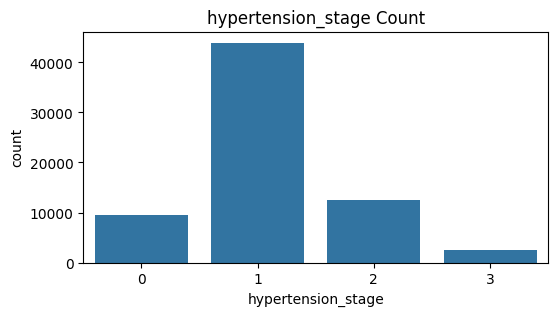

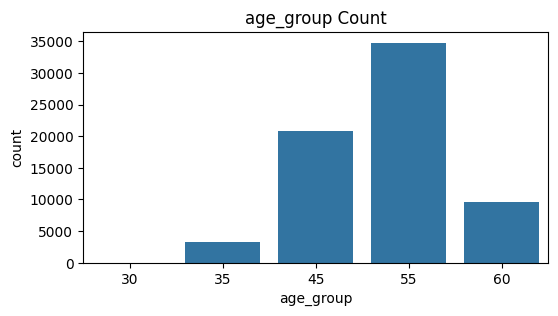

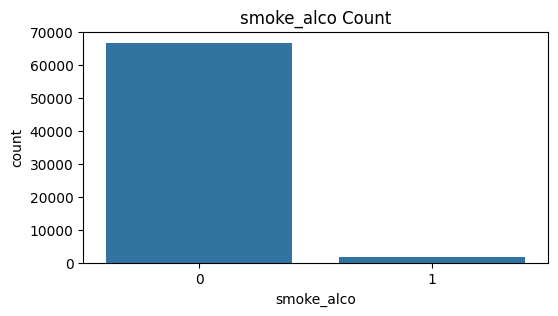

In [ ]:
# Categorical Features
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active',
            'hypertension_stage', 'age_group', 'smoke_alco']

for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Count')
    plt.show()


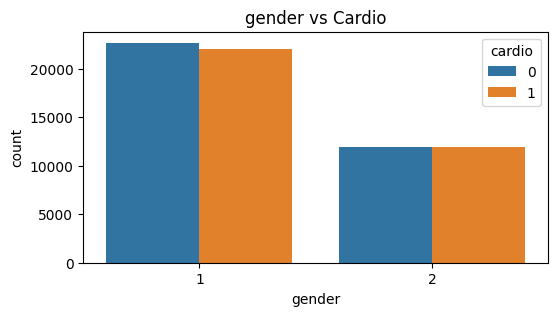

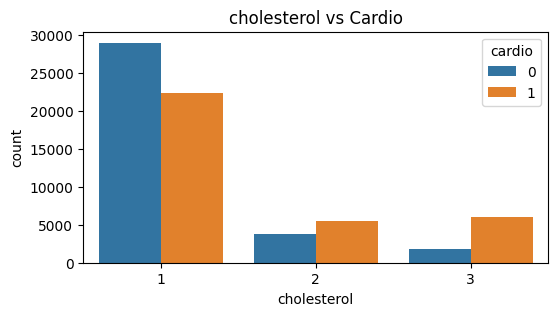

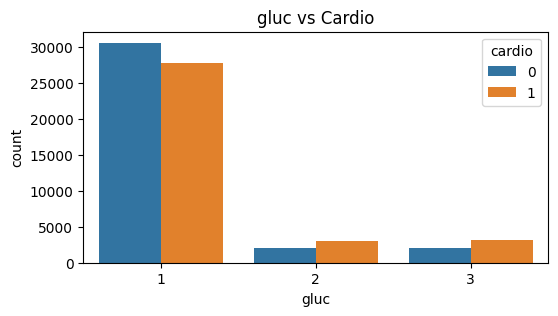

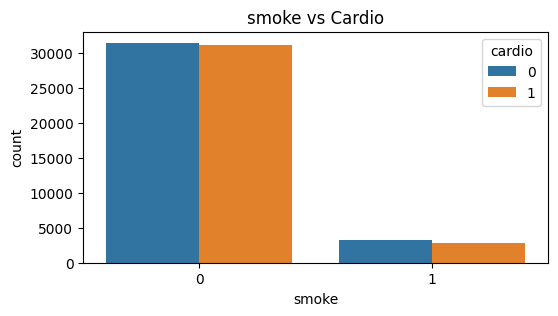

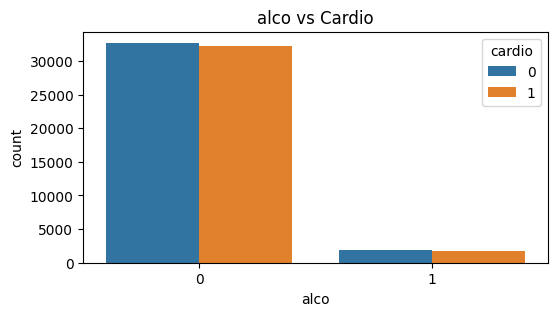

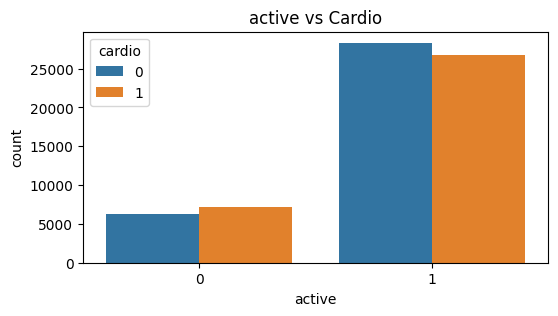

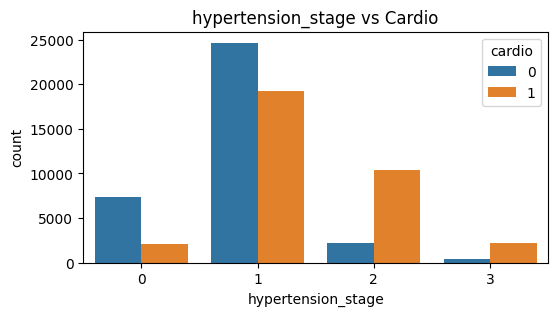

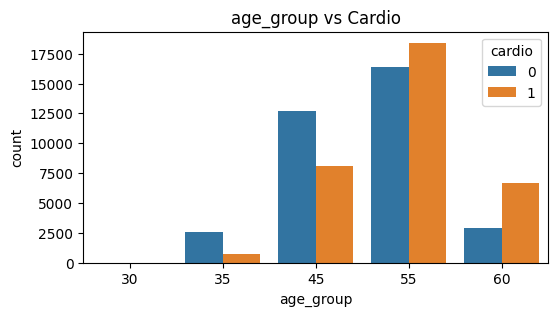

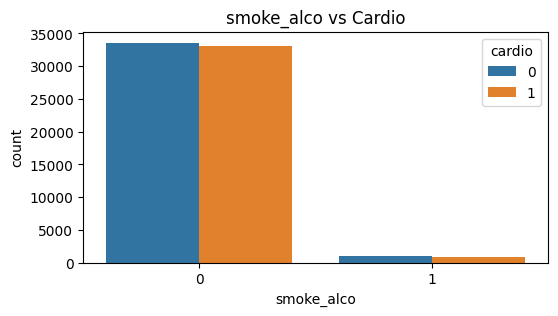

In [ ]:
# Target vs. Categorical Features
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='cardio', data=df)
    plt.title(f'{col} vs Cardio')
    plt.show()


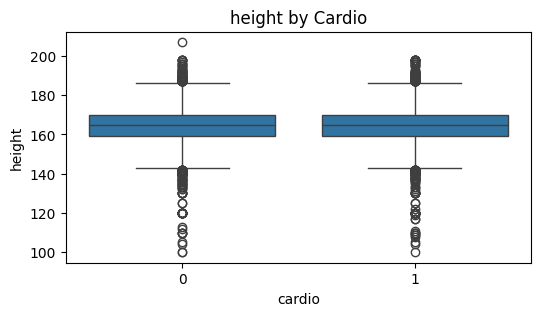

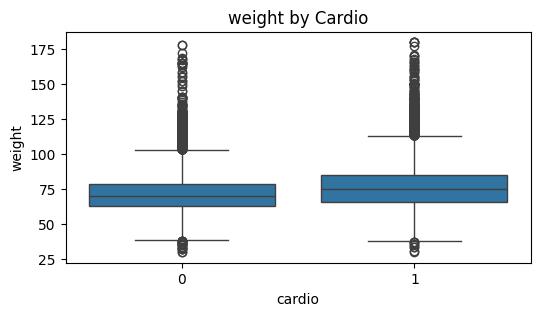

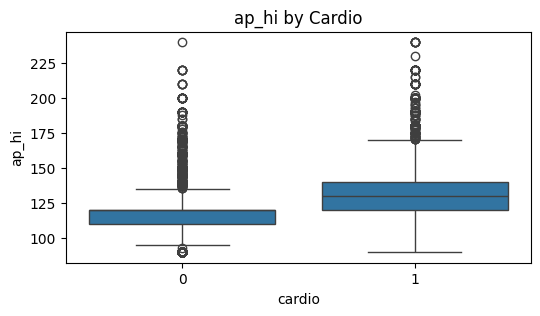

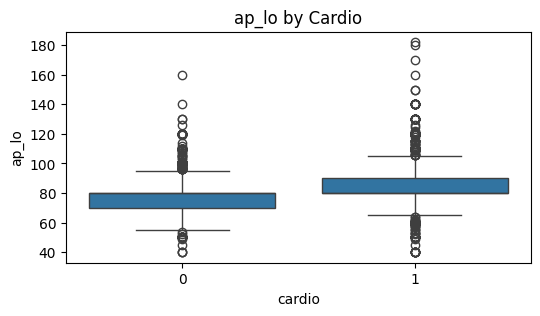

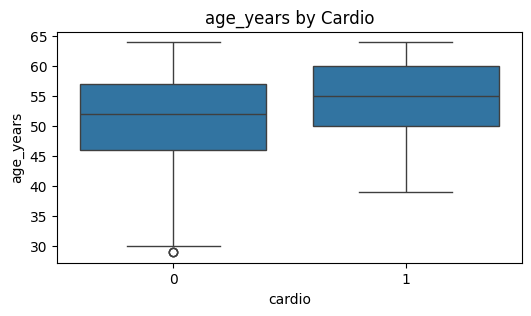

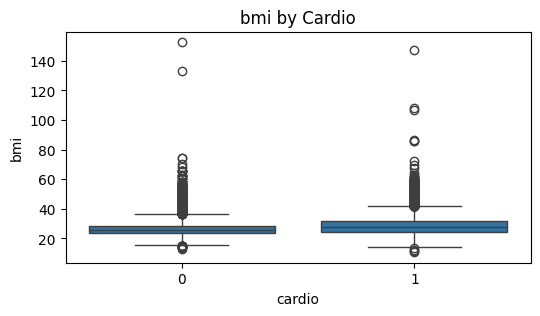

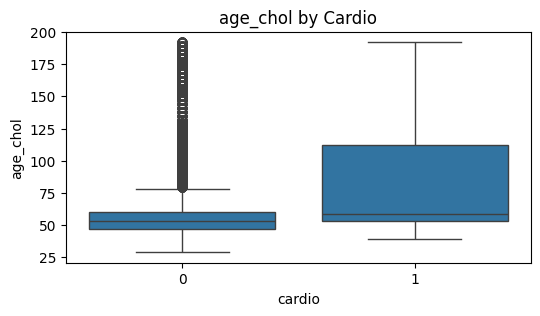

In [ ]:
# Target vs. Numerical Features (Boxplots)
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='cardio', y=col, data=df)
    plt.title(f'{col} by Cardio')
    plt.show()


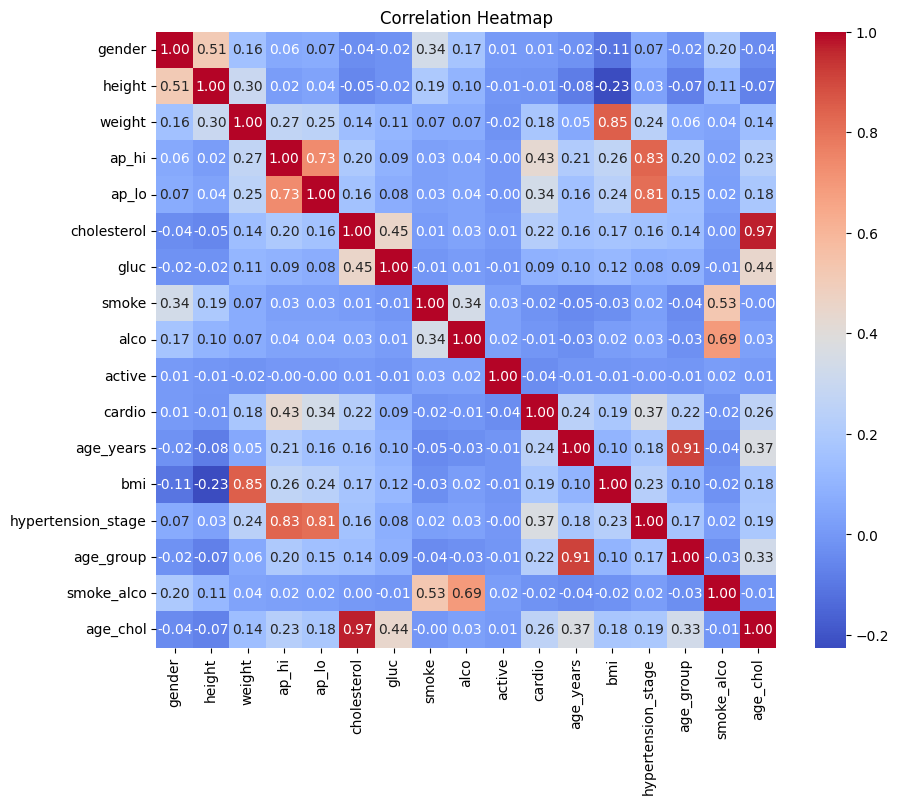

In [ ]:
# # Convert all columns to numeric where possible, ignore errors for non-numeric
df_numeric = df.copy()
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
summary = df.describe(include='all').T
summary['missing'] = df.isnull().sum()
print(summary)

                      count unique  top   freq        mean        std  \
gender              68562.0    NaN  NaN    NaN    1.348721   0.476569   
height              68562.0    NaN  NaN    NaN  164.397771   7.975034   
weight              68562.0    NaN  NaN    NaN   74.127008  14.279906   
ap_hi               68562.0    NaN  NaN    NaN  126.726335  16.632658   
ap_lo               68562.0    NaN  NaN    NaN   81.332342   9.427399   
cholesterol         68562.0    NaN  NaN    NaN    1.364823   0.679089   
gluc                68562.0    NaN  NaN    NaN    1.225839   0.571758   
smoke               68562.0    NaN  NaN    NaN    0.087906    0.28316   
alco                68562.0    NaN  NaN    NaN    0.053309   0.224651   
active              68562.0    NaN  NaN    NaN    0.803492    0.39736   
cardio              68562.0    NaN  NaN    NaN    0.495128    0.49998   
age_years           68562.0    NaN  NaN    NaN   52.832327    6.76773   
bmi                 68562.0    NaN  NaN    NaN   27

**1.5 EDA Summary**

The dataset consists of 68,562 entries with no missing values across any of the 17 features, ensuring a robust foundation for analysis. The population is relatively balanced in terms of gender, with a slight skew towards one group (mean=1.35 on a 1/2 scale). The average age is approximately 53 years, and the mean BMI is 27.5, indicating a population that trends toward being overweight. Blood pressure readings (ap_hi and ap_lo) show a wide range, with means of 128 and 81, respectively, and some extreme values suggesting the presence of outliers. The target variable, cardio, is nearly balanced (mean≈0.5), which is ideal for predictive modeling. Categorical health indicators such as cholesterol and glucose are mostly at their baseline levels, but a significant portion of the population displays elevated values, which could be clinically relevant for cardiovascular risk.

Correlation analysis reveals several important relationships among the features. As expected, systolic and diastolic blood pressure (ap_hi and ap_lo) are strongly correlated (r=0.73), and BMI shows a high correlation with weight (r=0.85) and a moderate correlation with hypertension stage (r=0.81). Age and age_group are almost perfectly correlated (r=0.91), indicating that the age_group variable is a direct transformation of age. Interestingly, the target variable cardio is moderately correlated with features such as age_years (r=0.24), systolic blood pressure (ap_hi, r=0.43), and cholesterol (r=0.24), suggesting these factors are significant risk indicators for cardiovascular disease in this dataset. Engineered features like smoke_alco and age_chol show moderate correlations with their component variables, confirming their validity. Overall, the dataset is well-structured for further modeling, with meaningful relationships among clinical and lifestyle variables relevant to cardiovascular health.

**2. Modeling Baseline**

**2.1 Data split**

In [ ]:
# Separate features and target
X = df.drop('cardio', axis=1)
y = df['cardio']

# Split into train and test (80% train, 20% test), stratified to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**2.2 Base line model: Logistic Regression**

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression:")
print("AUC:", roc_auc_score(y_test, lr_probs))
print("F1:", f1_score(y_test, lr_preds))
print("Accuracy:", accuracy_score(y_test, lr_preds))



Logistic Regression:
AUC: 0.7937029180867515
F1: 0.7096171802054155
Accuracy: 0.7278494858893021


**3.1 Baseline DT**

[DT-Baseline] Train time: 0.55s
=== DT Baseline - Classification Report ===
              precision    recall  f1-score   support

           0     0.6299    0.6424    0.6361      6923
           1     0.6278    0.6152    0.6214      6790

    accuracy                         0.6289     13713
   macro avg     0.6289    0.6288    0.6287     13713
weighted avg     0.6289    0.6289    0.6288     13713

[DT-Baseline] ROC-AUC: 0.6304
[DT-Baseline] PR-AUC : 0.5812


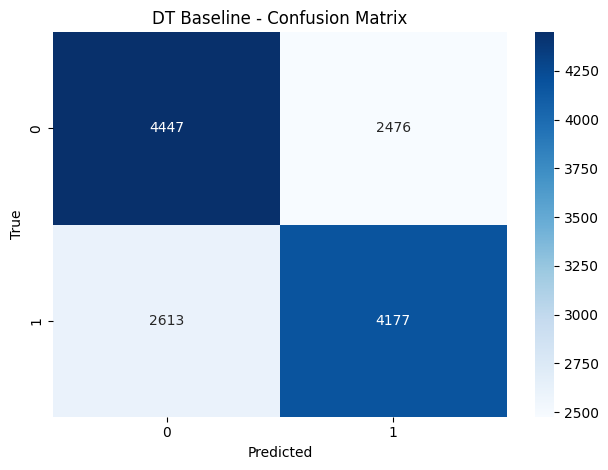

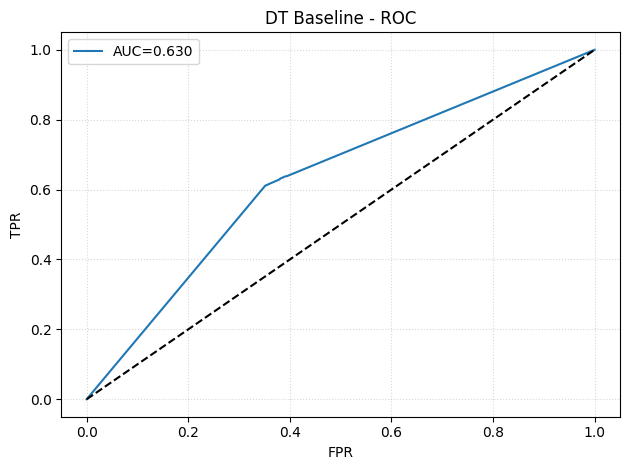

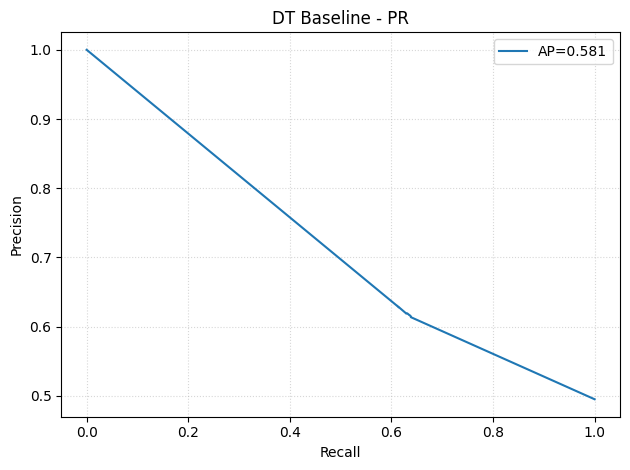

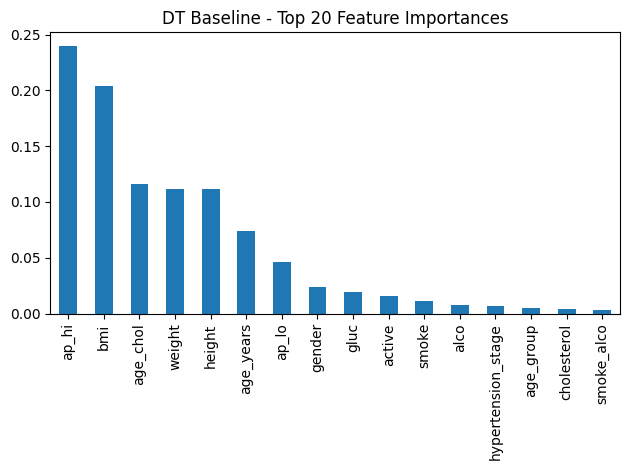

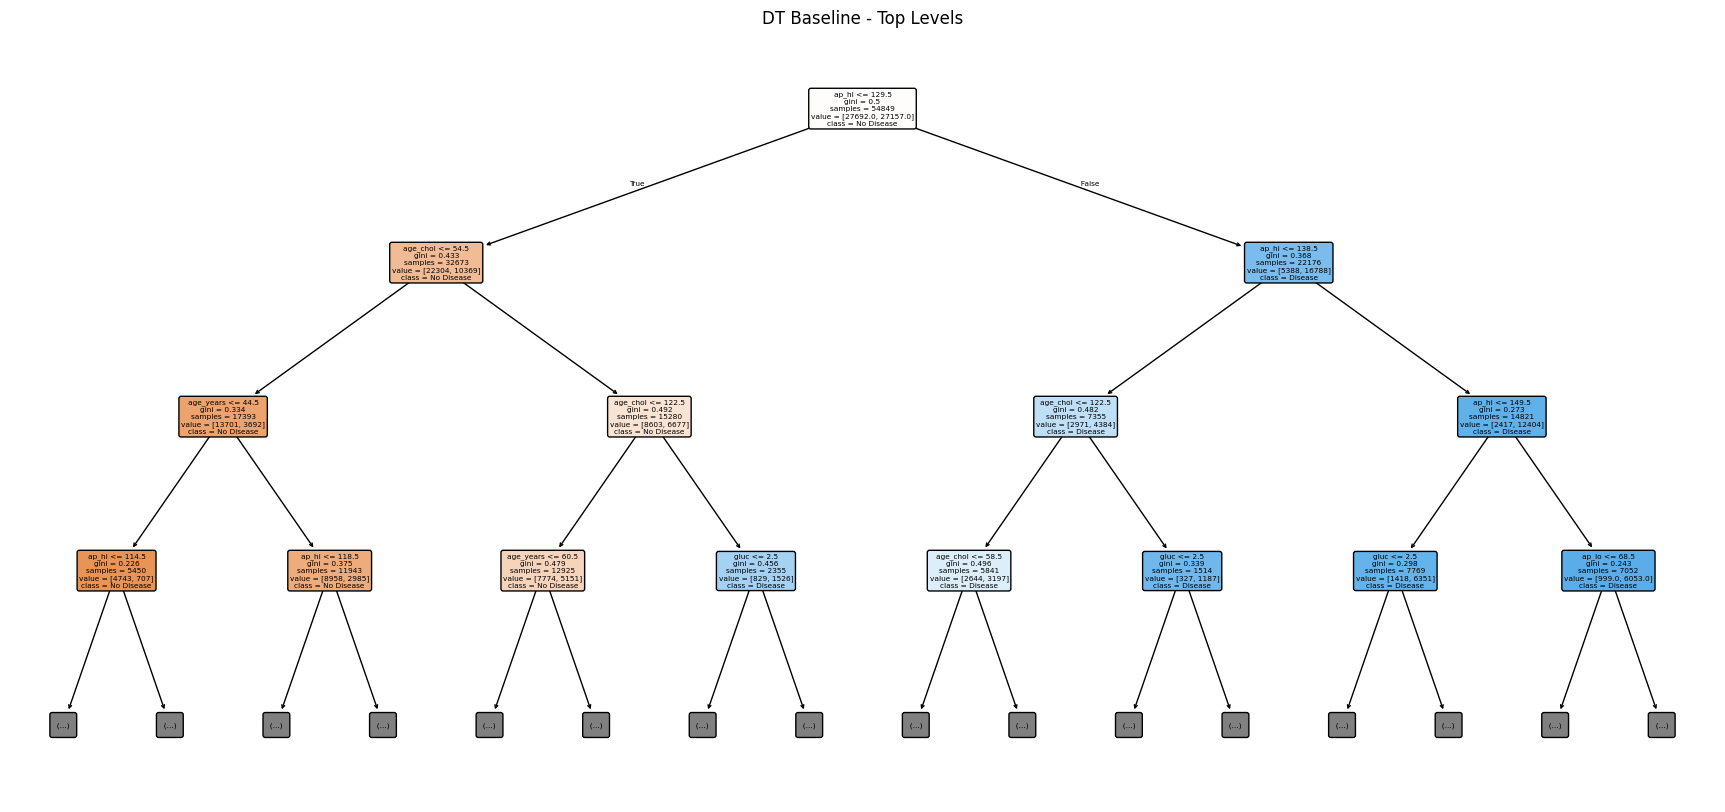

In [ ]:
# ========== 1) Baseline DT ==========
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

# For reproducibility across runs
RANDOM_STATE = 42

# ----- Model: plain Decision Tree as a quick baseline -----
dt_base = DecisionTreeClassifier(
    random_state=RANDOM_STATE
)

# ----- Train -----
t0 = time.time()
dt_base.fit(X_train, y_train)
print(f"[DT-Baseline] Train time: {time.time()-t0:.2f}s")

# ----- Predict (labels and probabilities) -----
y_pred = dt_base.predict(X_test)
# For ROC/PR curves we need positive-class probabilities (assumed to be column 1)
y_proba = dt_base.predict_proba(X_test)[:, 1]

# ----- Classification metrics (threshold-based on y_pred) -----
print("=== DT Baseline - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# ----- Ranking metrics (threshold-free on y_proba) -----
dtb_roc = roc_auc_score(y_test, y_proba)                # Area under ROC
dtb_pr  = average_precision_score(y_test, y_proba)      # Area under PR (Average Precision)
print(f"[DT-Baseline] ROC-AUC: {dtb_roc:.4f}")
print(f"[DT-Baseline] PR-AUC : {dtb_pr:.4f}")

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("DT Baseline - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC={dtb_roc:.3f}')
plt.plot([0,1],[0,1],'k--')  # random classifier line
plt.title("DT Baseline - ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True, ls=":", alpha=.5)
plt.tight_layout()
plt.show()

# ----- Precision-Recall Curve -----
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, label=f'AP={dtb_pr:.3f}')
plt.title("DT Baseline - PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, ls=":", alpha=.5)
plt.tight_layout()
plt.show()

# ----- Feature Importance (top 20) -----
# Only available if X_train is a DataFrame with column names
if hasattr(X_train, "columns"):
    fi = pd.Series(dt_base.feature_importances_, index=X_train.columns)\
         .sort_values(ascending=False).head(20)
    plt.figure()
    fi.plot.bar()
    plt.title("DT Baseline - Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

# ----- Visualize top levels of the tree (for quick interpretability) -----
plt.figure(figsize=(22,10))
plot_tree(
    dt_base,
    feature_names=getattr(X_train, "columns", None),
    class_names=["No Disease","Disease"],  # adjust to your actual class names if different
    filled=True, rounded=True, max_depth=3
)
plt.title("DT Baseline - Top Levels")
plt.show()


**3.2  RandomizedSearchCV**

In [ ]:
#  RandomizedSearchCV for Decision Tree tuning
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

# Create a stratified k-fold CV object (preserves class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Define search space for hyperparameters
param_distributions = {
    "max_depth": randint(4, 11),            # Tree depth: integers 4 to 10
    "min_samples_split": randint(20, 201),  # Min samples to split a node: 20 to 200
    "min_samples_leaf": randint(10, 51),    # Min samples at a leaf: 10 to 50
    "max_features": [None, "sqrt", "log2", 0.5],  # Feature subset strategy
    "min_impurity_decrease": uniform(1e-4, 0.02), # Min impurity decrease for split
    "class_weight": [None, "balanced"]      # Option to handle class imbalance
}

# Base Decision Tree model
dt0 = DecisionTreeClassifier(random_state=RANDOM_STATE)

# RandomizedSearchCV: randomly samples parameter combinations
rs = RandomizedSearchCV(
    estimator=dt0,
    param_distributions=param_distributions,
    n_iter=80,                  # Number of random parameter sets to try
    scoring="roc_auc",          # Optimize for ROC-AUC score
    cv=cv,                       # Stratified k-fold cross-validation
    n_jobs=-1,                   # Use all available CPU cores
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit search on training data
rs.fit(X_train, y_train)
print("DT RandomizedSearch best  paras：", rs.best_params_)
print("DT Best CV ROC-AUC:", rs.best_score_)

# Evaluate tuned model on test set
dt_tuned = rs.best_estimator_
proba_tuned = dt_tuned.predict_proba(X_test)[:, 1]
print("DT Test ROC-AUC (tuned):", roc_auc_score(y_test, proba_tuned))
print("DT Test PR-AUC  (tuned):", average_precision_score(y_test, proba_tuned))
acc_tuned = accuracy_score(y_test, dt_tuned.predict(X_test))
print("DT Test Accuracy (tuned):", acc_tuned)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
DT RandomizedSearch best  paras： {'class_weight': None, 'max_depth': 8, 'max_features': None, 'min_impurity_decrease': np.float64(0.00041272813482387863), 'min_samples_leaf': 18, 'min_samples_split': 107}
DT Best CV ROC-AUC: 0.7903595894281158
DT Test ROC-AUC (tuned): 0.7899175912951151
DT Test PR-AUC  (tuned): 0.7569045831715314
DT Test Accuracy (tuned): 0.7275577918763217


In [ ]:
from scipy.stats import ttest_rel


from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_base = cross_val_score(dt_base, X_train, y_train, cv=cv, scoring="roc_auc")
scores_tuned = cross_val_score(dt_tuned, X_train, y_train, cv=cv, scoring="roc_auc")

print(f"Baseline DT CV ROC-AUC: {scores_base.mean():.4f} ± {scores_base.std():.4f}")
print(f"Tuned DT CV ROC-AUC   : {scores_tuned.mean():.4f} ± {scores_tuned.std():.4f}")

t_stat, p_val = ttest_rel(scores_tuned, scores_base)
print(f"Paired t-test: t={t_stat:.4f}, p={p_val:.4f}")


Baseline DT CV ROC-AUC: 0.6328 ± 0.0045
Tuned DT CV ROC-AUC   : 0.7904 ± 0.0040
Paired t-test: t=70.8664, p=0.0000


RF


[RF-Baseline] Train time: 10.59s
=== RF Baseline - Classification Report ===
              precision    recall  f1-score   support

           0     0.7086    0.7176    0.7131      6923
           1     0.7083    0.6991    0.7037      6790

    accuracy                         0.7085     13713
   macro avg     0.7084    0.7084    0.7084     13713
weighted avg     0.7084    0.7085    0.7084     13713

[RF-Baseline] ROC-AUC: 0.7662
[RF-Baseline] PR-AUC : 0.7464
[RF-Baseline] Accuracy: 0.7085
[RF-Baseline] F1: 0.7037


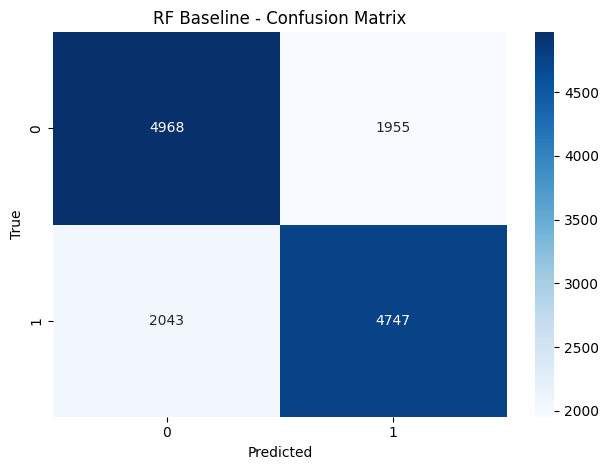

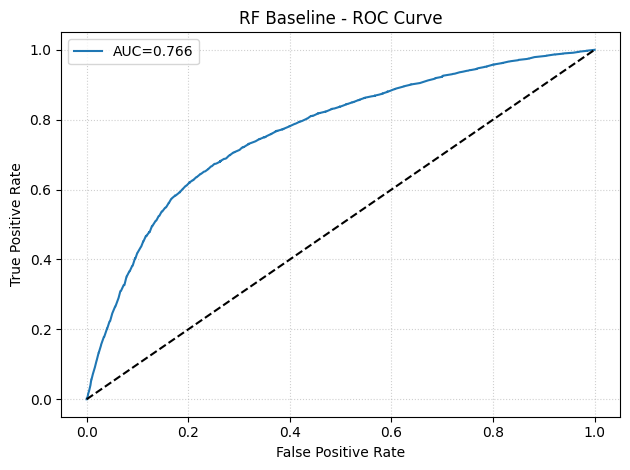

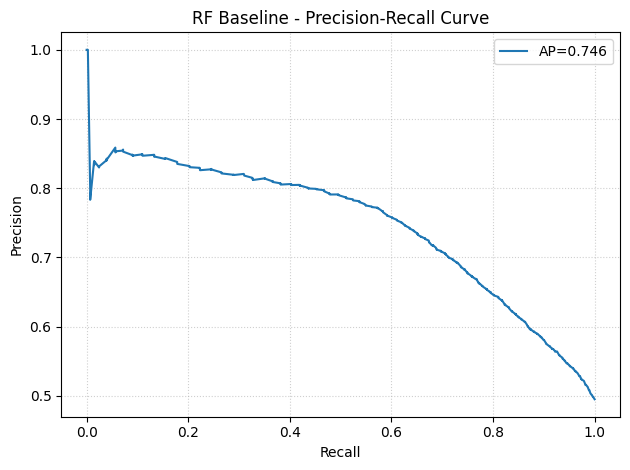

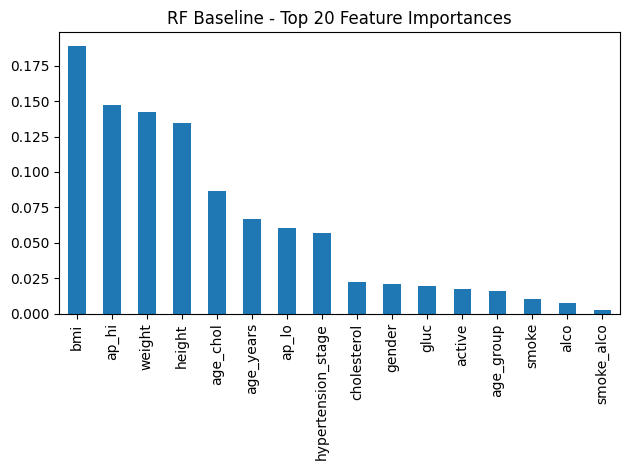

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, \
                            confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

RANDOM_STATE = 42

# ----- Baseline Random Forest -----
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1  # Use all available CPU cores
)

# Train the model and record training time
start_time = time.time()
rf_base.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"[RF-Baseline] Train time: {train_time:.2f}s")

# ----- Predictions -----
y_pred = rf_base.predict(X_test)              # Predicted class labels
y_proba = rf_base.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# ----- Classification report -----
print("=== RF Baseline - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# ----- Main metrics -----
rfb_roc = roc_auc_score(y_test, y_proba)                  # ROC-AUC
rfb_pr  = average_precision_score(y_test, y_proba)        # PR-AUC (Average Precision)
print(f"[RF-Baseline] ROC-AUC: {rfb_roc:.4f}")
print(f"[RF-Baseline] PR-AUC : {rfb_pr:.4f}")
print(f"[RF-Baseline] Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"[RF-Baseline] F1: {f1_score(y_test, y_pred):.4f}")

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("RF Baseline - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC={rfb_roc:.3f}')
plt.plot([0,1],[0,1],'k--')  # Random guess line
plt.title("RF Baseline - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Precision-Recall Curve -----
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, label=f'AP={rfb_pr:.3f}')
plt.title("RF Baseline - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Feature Importance -----
# Only display if X_train has column names (e.g., a DataFrame)
if hasattr(X_train, "columns"):
    fi = pd.Series(
        rf_base.feature_importances_,
        index=X_train.columns
    ).sort_values(ascending=False).head(20)
    plt.figure()
    fi.plot.bar()
    plt.title("RF Baseline - Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


RF（RandomizedSearchCV）

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import time

RANDOM_STATE = 42

# 3-fold stratified CV (preserves class balance in each fold)
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# ----- Stage 1: Baseline RandomForest with fixed n_estimators and sampling ratio -----
rf_stage1 = RandomForestClassifier(
    n_estimators=200,     # Number of trees in the forest
    max_samples=0.70,     # Use 70% of the training data for each tree (bootstrap sampling)
    bootstrap=True,       # Enable bootstrap sampling
    n_jobs=-1,            # Use all CPU cores
    random_state=RANDOM_STATE
)

# ----- Hyperparameter search space -----
dist1 = {
    "max_depth": [None] + list(range(6, 19)),     # None = unlimited depth; else 6 to 18
    "min_samples_split": randint(10, 151),        # Min samples to split a node: 10–150
    "min_samples_leaf": randint(5, 61),           # Min samples per leaf: 5–60
    "max_features": ["sqrt", "log2", 0.5, 0.7],   # Feature subset strategy
    "class_weight": [None, "balanced"]            # Handle imbalance or not
}

# ----- Randomized search -----
rs1 = RandomizedSearchCV(
    rf_stage1, dist1,
    n_iter=40,               # Number of random parameter sets to try
    scoring="roc_auc",       # Optimize for ROC-AUC
    cv=cv3,                  # 3-fold stratified CV
    n_jobs=-1,               # Use all CPU cores
    random_state=RANDOM_STATE,
    verbose=1                # Show progress
)

# ----- Train with search -----
t0 = time.time()
rs1.fit(X_train, y_train)
print(f"[Stage-1] time: {time.time()-t0:.1f}s")
print("Stage-1 best params:", rs1.best_params_)
print("Stage-1 best CV AUC:", rs1.best_score_)

# Store the best parameter combination from Stage 1
best_shape = rs1.best_params_.copy()


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Stage-1] time: 820.7s
Stage-1 best params: {'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 21}
Stage-1 best CV AUC: 0.8002200747146623


Tuned RF 评估

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

# 5-fold stratified CV (better estimate of generalization performance)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ----- Stage 2: Base RF using best params from Stage 1 (best_shape) -----
rf_stage2_base = RandomForestClassifier(
    max_samples=0.70,      # Use 70% of samples per tree
    bootstrap=True,        # Enable bootstrap sampling
    n_jobs=-1,              # Use all CPU cores
    random_state=RANDOM_STATE,
    **best_shape            # Insert best hyperparameters from Stage 1 search
)

# ----- Grid search over number of trees -----
grid2 = GridSearchCV(
    rf_stage2_base,
    param_grid={"n_estimators": [300, 500, 700, 900]},  # Candidate tree counts
    scoring="roc_auc",   # Optimize for ROC-AUC
    cv=cv5,              # 5-fold stratified CV
    n_jobs=-1,           # Parallelize across CPU cores
    verbose=1
)

# ----- Train and search -----
t0 = time.time()
grid2.fit(X_train, y_train)
print(f"[Stage-2] time: {time.time()-t0:.1f}s")
print("Stage-2 best n_estimators:", grid2.best_params_)
print("Stage-2 best CV ROC-AUC:", grid2.best_score_)

# Final tuned Random Forest model
rf_tuned = grid2.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Stage-2] time: 375.0s
Stage-2 best n_estimators: {'n_estimators': 700}
Stage-2 best CV ROC-AUC: 0.8002451646520692


5-fold CV 对比 + 配对 t-test

=== RF Tuned - Classification Report ===
              precision    recall  f1-score   support

           0     0.7180    0.7751    0.7454      6923
           1     0.7504    0.6895    0.7187      6790

    accuracy                         0.7327     13713
   macro avg     0.7342    0.7323    0.7321     13713
weighted avg     0.7340    0.7327    0.7322     13713

[RF-Tuned] Accuracy=0.7327 F1=0.7187 ROC-AUC=0.8025 PR-AUC=0.7836


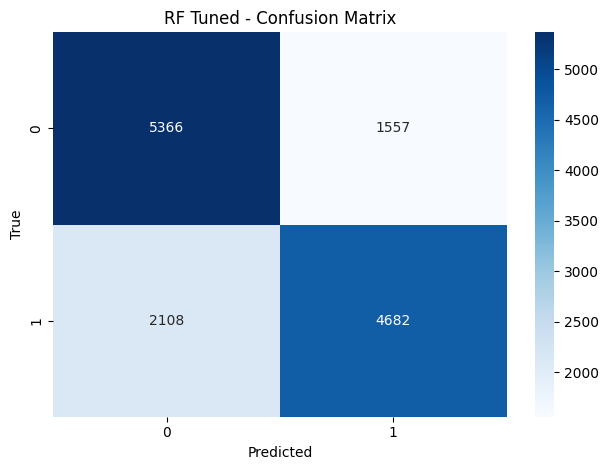

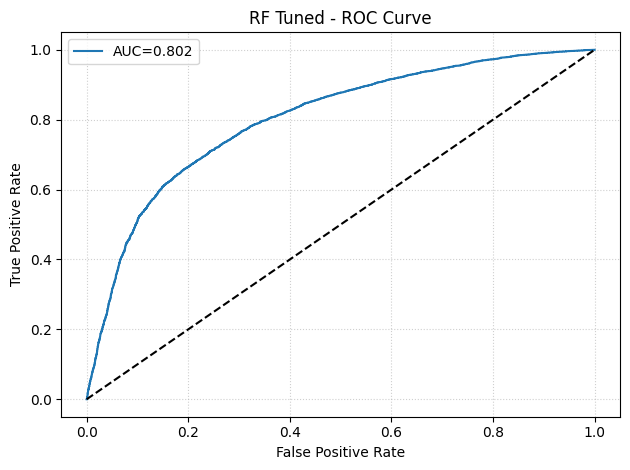

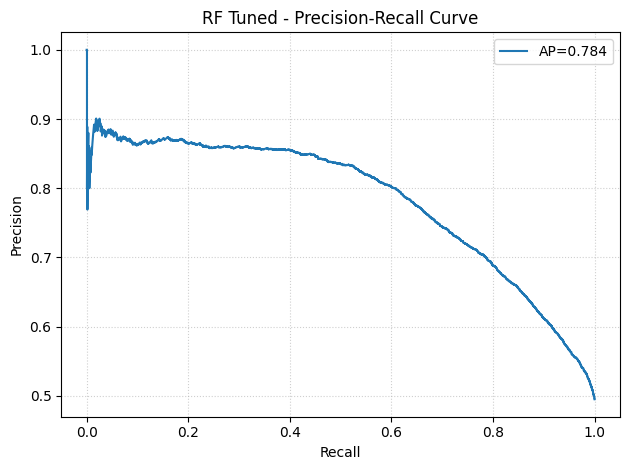

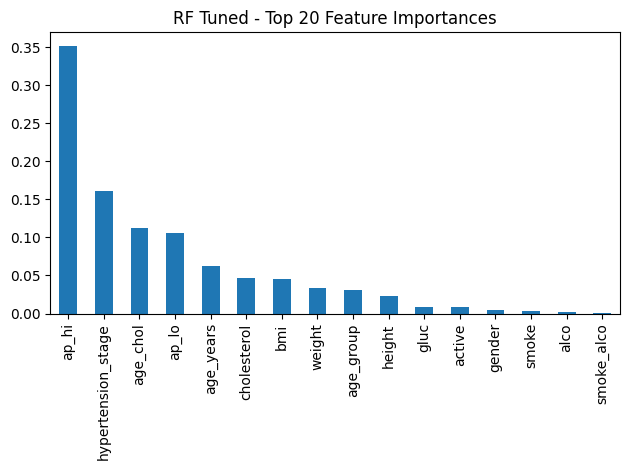

RF Baseline CV ROC-AUC: 0.7645 ± 0.0054
RF Tuned   CV ROC-AUC: 0.8002 ± 0.0043
Paired t-test: t=30.0262, p=0.000007


,Model,Accuracy,F1,ROC_AUC,PR_AUC
1,RF - Tuned,0.732735,0.718704,0.802479,0.783588
0,RF - Baseline,0.708452,0.703676,0.766208,0.746377


Saved to figures_metrics/rf_compare.csv


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, roc_curve, precision_recall_curve)
from scipy.stats import ttest_rel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ----- Evaluate tuned RF on test set -----
y_pred_tuned  = rf_tuned.predict(X_test)               # Predicted labels
y_proba_tuned = rf_tuned.predict_proba(X_test)[:, 1]   # Probabilities for positive class

print("=== RF Tuned - Classification Report ===")
print(classification_report(y_test, y_pred_tuned, digits=4))

# Calculate key metrics
acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned  = f1_score(y_test, y_pred_tuned)
roc_tuned = roc_auc_score(y_test, y_proba_tuned)
pr_tuned  = average_precision_score(y_test, y_proba_tuned)
print(f"[RF-Tuned] Accuracy={acc_tuned:.4f} F1={f1_tuned:.4f} ROC-AUC={roc_tuned:.4f} PR-AUC={pr_tuned:.4f}")

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("RF Tuned - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC={roc_tuned:.3f}')
plt.plot([0, 1], [0, 1], "k--")  # Random chance line
plt.title("RF Tuned - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Precision-Recall Curve -----
precision, recall, _ = precision_recall_curve(y_test, y_proba_tuned)
plt.figure()
plt.plot(recall, precision, label=f'AP={pr_tuned:.3f}')
plt.title("RF Tuned - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Feature Importances -----
if hasattr(X_train, "columns"):
    fi = pd.Series(
        rf_tuned.feature_importances_,
        index=X_train.columns
    ).sort_values(ascending=False).head(20)
    plt.figure()
    fi.plot.bar()
    plt.title("RF Tuned - Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

# ----- Cross-validation comparison with baseline RF -----
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)  # Baseline RF

# Cross-validated ROC-AUC for baseline and tuned models
scores_base  = cross_val_score(rf_base,  X_train, y_train, cv=cv5, scoring="roc_auc", n_jobs=-1)
scores_tuned = cross_val_score(rf_tuned, X_train, y_train, cv=cv5, scoring="roc_auc", n_jobs=-1)

print(f"RF Baseline CV ROC-AUC: {scores_base.mean():.4f} ± {scores_base.std():.4f}")
print(f"RF Tuned   CV ROC-AUC: {scores_tuned.mean():.4f} ± {scores_tuned.std():.4f}")

# Paired t-test to check statistical significance of difference
t_stat, p_val = ttest_rel(scores_tuned, scores_base)
print(f"Paired t-test: t={t_stat:.4f}, p={p_val:.6f}")

# ----- Evaluate baseline RF on test set for comparison -----
rf_base.fit(X_train, y_train)
y_pred_base  = rf_base.predict(X_test)
y_proba_base = rf_base.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred_base)
f1_base  = f1_score(y_test, y_pred_base)
roc_base = roc_auc_score(y_test, y_proba_base)
pr_base  = average_precision_score(y_test, y_proba_base)

# ----- Combine results into comparison table -----
rows = [
    {"Model": "RF - Baseline", "Accuracy": acc_base, "F1": f1_base, "ROC_AUC": roc_base, "PR_AUC": pr_base},
    {"Model": "RF - Tuned",    "Accuracy": acc_tuned, "F1": f1_tuned, "ROC_AUC": roc_tuned, "PR_AUC": pr_tuned}
]

rf_compare = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False)
display(rf_compare)

# ----- Save comparison table -----
os.makedirs("figures_metrics", exist_ok=True)
rf_compare.to_csv("figures_metrics/rf_compare.csv", index=False)
print("Saved to figures_metrics/rf_compare.csv")
